# Using Generative Adversarial Networks to Create images of Dogs

Aim of the notebook: Practice - Build a GANs to help create fake images of dogs. 

Based on the Kaggle Challenge Dog Images - https://www.kaggle.com/c/generative-dog-images.

The dataset is comprised of 20580 annotated images of over 120 dog breeds from a publicly available dataset known as the Standford Dogs Dataset. 

## Import the Libraries 

In [27]:
import pandas as pd
import numpy as np

import os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt 
from PIL import Image
import tensorflow as tf
from tensorflow import keras

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam

## Import the Data

In [12]:
# import the breeds
directory = '/Users/georgebrockman/code/georgebrockman/Autoenhance.ai/DogGenerator/'
breeds = os.listdir(directory + 'Annotation/')

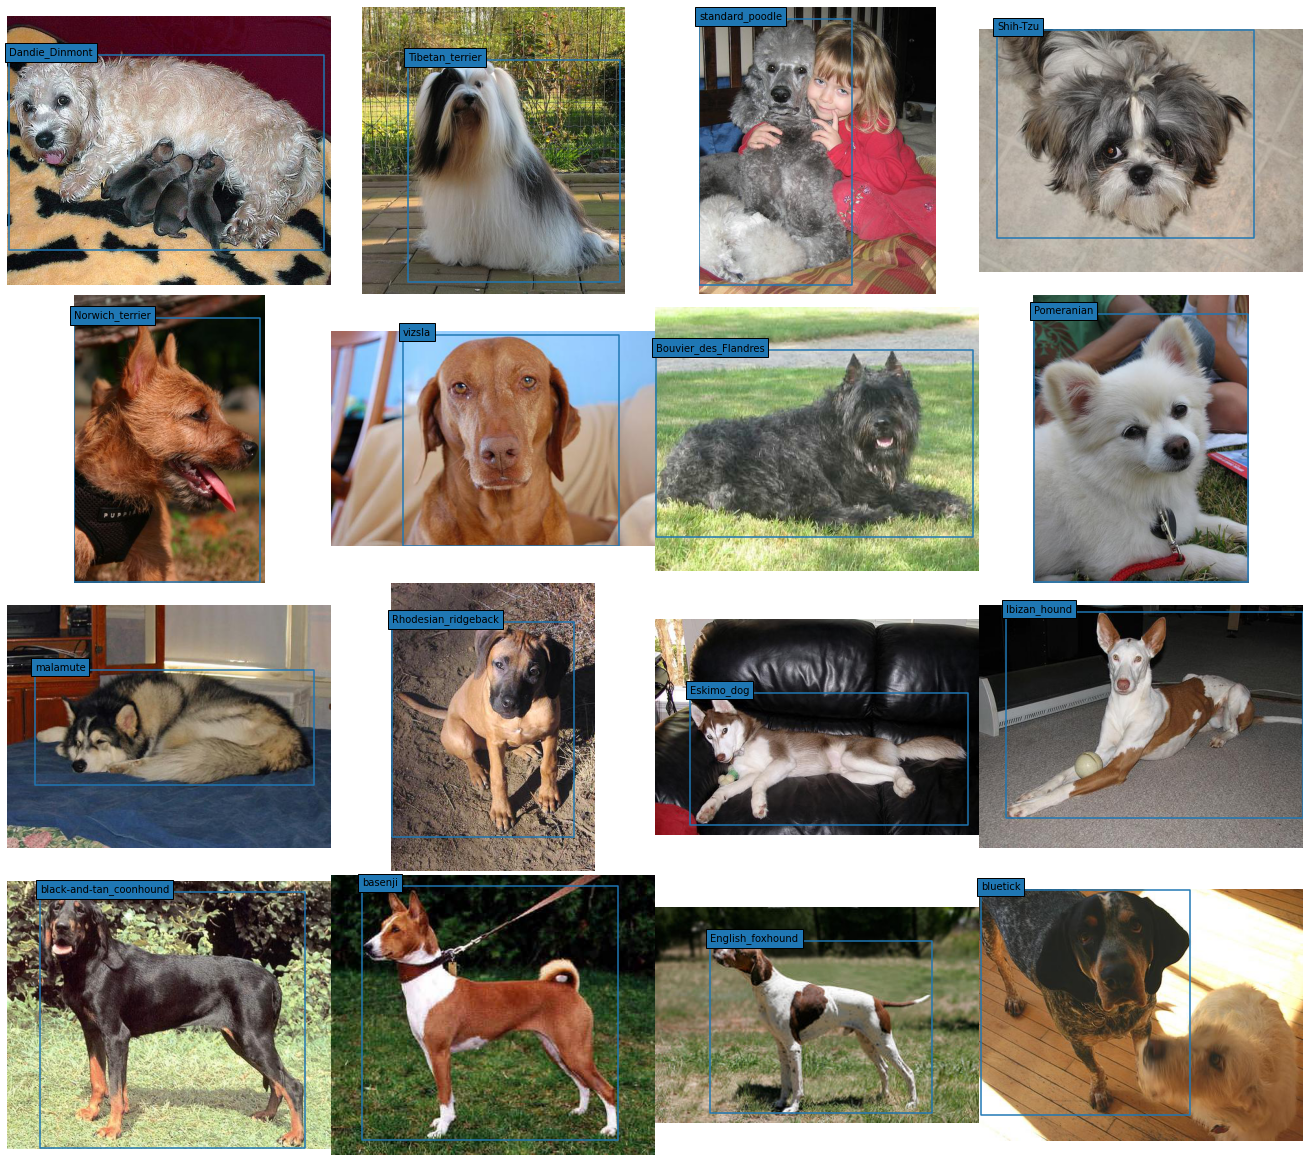

In [24]:
# crop the images to just contain dogs and annotations
# reducing the noise should help the GANs to generate better images of dogs quicker. 
# This code was taken from Paulo Pinto

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18,16))
for indx, axis in enumerate(axes.flatten()):
    breed = np.random.choice(breeds)
    dog = np.random.choice(os.listdir(directory + 'Annotation/'+ breed))
    img = Image.open(directory + 'all-dogs/' + dog + '.jpg') 
    tree = ET.parse(directory + 'Annotation/'+ breed + '/' + dog)
    root = tree.getroot()
    objects = root.findall('object')
    axis.set_axis_off() 
    imgplot = axis.imshow(img)
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        axis.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin]) # show box
        axis.text(xmin, ymin, o.find('name').text, bbox={'ec': None}) # show breed

plt.tight_layout(pad=0, w_pad=0, h_pad=0)

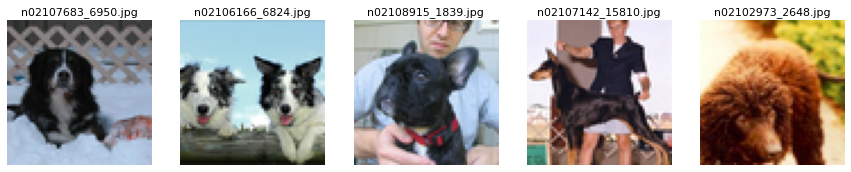

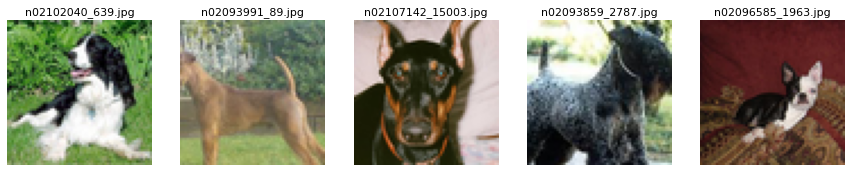

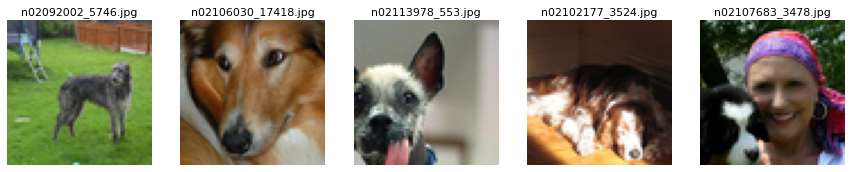

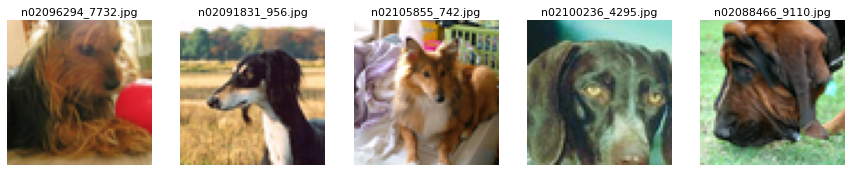

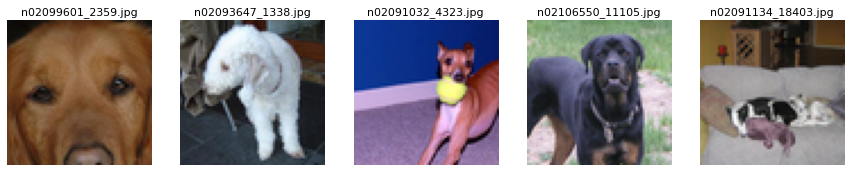

In [37]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '/Users/georgebrockman/code/georgebrockman/Autoenhance.ai/DogGenerator/'
IMAGES = os.listdir(ROOT + 'all-dogs/')
breeds = os.listdir(ROOT + 'Annotation/') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT + 'Annotation/'+ breed):
            try: img = Image.open(ROOT + 'all-dogs/' + dog + '.jpg') 
            except: continue           
            tree = ET.parse(ROOT + 'Annotation/'+ breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
                
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20000),10000)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))  
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()


## Building the Generative Network

In [28]:
# BUILD GENERATIVE NETWORK
direct_input = Input((10000,))
x = Dense(2048, activation='elu')(direct_input)
x = Reshape((8,8,32))(x)
x = Conv2D(128, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='elu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# COMPILE
decoder = Model(direct_input, decoded)
decoder.compile(optimizer=Adam(lr=0.005), loss='binary_crossentropy')

# DISPLAY ARCHITECTURE
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense (Dense)                (None, 2048)              20482048  
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 128)         36992     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 32, 32, 64)        0     

## Training

In [40]:
# TRAINING DATA
idx = np.random.randint(0,idxIn,10000)
train_y = imagesIn[idx,:,:,:]/255.
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1

In [41]:
# TRAIN NETWORK

# learning rate = 0.005
lr = 0.005
for k in range(50):
    annealer = LearningRateScheduler(lambda x: lr)
    h = decoder.fit(train_X, train_y, epochs = 10, batch_size=256, callbacks=[annealer], verbose=0)
    if k%5==4: print('Epoch',(k+1)*10,'/500 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.54: lr = 0.001


Epoch 50 /500 - loss = 0.5410416126251221
Epoch 100 /500 - loss = 0.5370689034461975
Epoch 150 /500 - loss = 0.5363186001777649


KeyboardInterrupt: 

In [42]:
# re-run in google co lab

In [ ]:
# delete training network so that the generative network can stand alone without the assistance of training images
del train_X, train_y, imagesIn

Generate Random Dogs


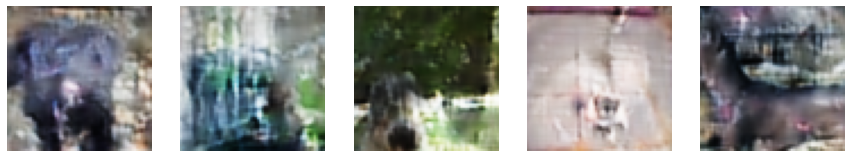

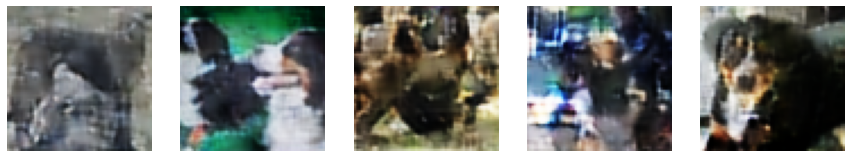

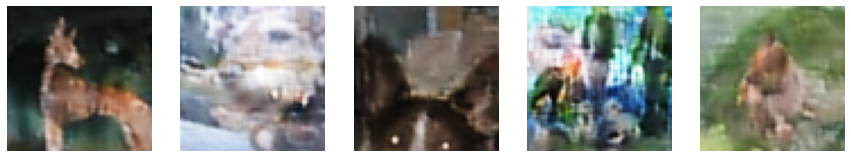

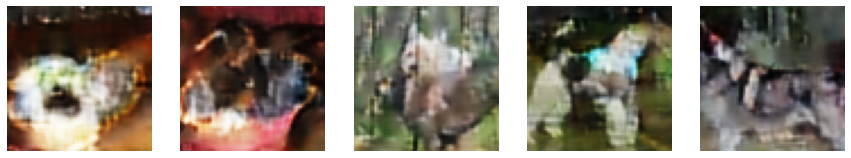

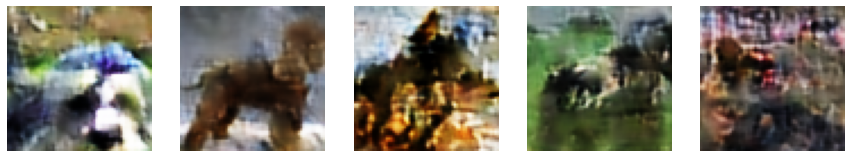

In [43]:
print('Generate Random Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        xx[np.random.randint(10000)] = 0.75
        #xx[np.random.randint(10000)] = 0.25
        xx = xx/(np.sqrt(xx.dot(xx.T)))
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

Recall from Memory Dogs


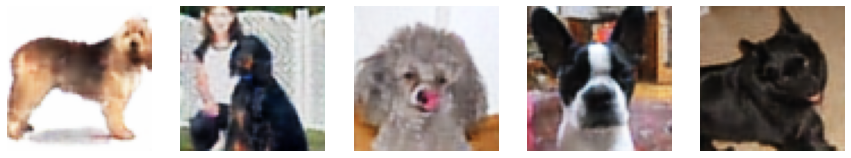

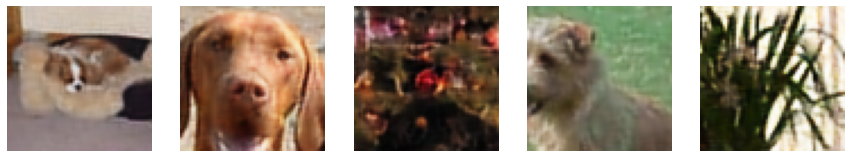

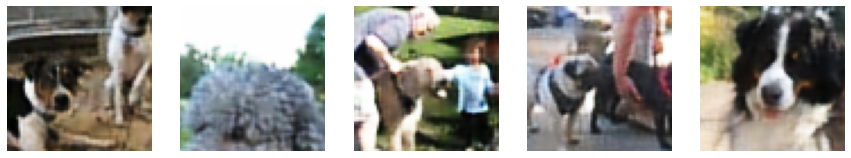

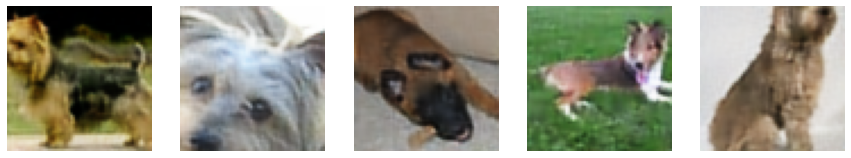

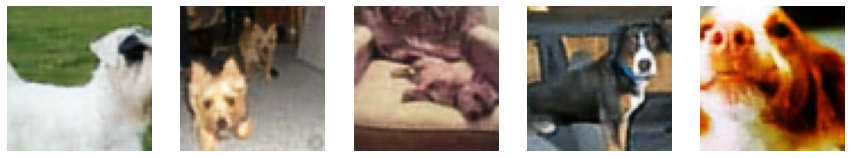

In [44]:
print('Recall from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = decoder.predict(xx.reshape((-1,10000)))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()